# **GeoMapCLIP Demo:** Worldwide Map Image Geo-localization 🌎📍

Over the past two decades, anthropology and archaeology have shifted from paper-based data collection to digital workflows, leveraging innovations like tablet computing, web GIS, remote sensing, LiDAR, and open-access repositories. <br> However, traditional analog data in archaeological reports, field notes, and sketch maps remain underutilized due to the challenges of digitization and integration. <br> These legacy datasets contain valuable historical and spatial information. However, extracting geospatial details—such as site locations described textually or in hand-drawn maps—is labor-intensive and limits scalability.
<br><br>
This project aims to develop a vision system capable of interpreting map images and extracting bounding box coordinates to describe map content. <br>
By fine-tuning models such as CLIP and applying image retrieval techniques, the system will learn to recognize legends, scales, symbols, and coordinate grids within geospatial maps, enabling automated extraction of structured spatial information. <br>This advancement will significantly enhance the geospatial reasoning capabilities of large language models, supporting researchers in efficiently querying and leveraging legacy geospatial datasets. 

Initial development will focus on fine-tuning GeoCLIP (Contrastive Language-Image Pretraining) for map-specific tasks. The vision system will produce a list of coordinates corresponding to visual elements in map figures. 

## For more information about GeoCLIP, please check out their [paper](https://arxiv.org/abs/2309.16020v2) and [GitHub repository](https://github.com/VicenteVivan/geo-clip)

Notebook Comparison: GeoCLIP vs. GeoMapCLIP

This notebook evaluates how coordinate inference results differ between GeoCLIP and GeoMapCLIP:

1. GeoCLIP was pre-trained on natural images, such as those from Twitter.

2. GeoMapCLIP was fine-tuned on map tiles using GeoCLIP as a base.

3. By comparing their predictions, we assess how map-specific fine-tuning improves coordinate inference for geospatial imagery.

## Setting Up Your Environment 🛠️

To ensure a much faster inference, please follow these steps to use a GPU runtime:

1. Go to the menu at the top of this notebook, and select `Runtime` > `Change runtime type`.
2. Under `Hardware accelerator`, select `GPU` and click `Save`.
3. You can verify the GPU allocated to this session by running the following cell:

In [1]:
import sys, os
import torch

## Installation 📦

In [2]:
%pip install -U geomapclip

# if you want to locally modify the GeoMapCLIP, do this
# Adds the parent directory of the notebook (i.e., repo root)
# sys.path.append(os.path.abspath(".."))

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install geoclip

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Importing Libraries and Model Initialization 🛠️

## import libraries and GeoMapCLIP model Initialization 

In [4]:
from geomapclip import GeoMapCLIP

gmc_device = "cpu"

gmc_model = GeoMapCLIP().to(gmc_device)
print("===========================")
print("GeoMapCLIP has been loaded! 🎉")
print("===========================")


GeoMapCLIP has been loaded! 🎉


In [5]:
from geoclip import GeoCLIP

gc_model = GeoCLIP().to("cpu")
print("===========================")
print("GeoCLIP has been loaded! 🎉")
print("===========================")

GeoCLIP has been loaded! 🎉


In [6]:
# if the kernel does not have them, install these packages
%pip install matplotlib
%pip install folium

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Image Upload & Display
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# Heatmap
import folium
from folium.plugins import HeatMap

## Uploading an Image 🌃

## If you want to upload your image, please upload one to the Jupyter notebook's file browser, and update the image_path accordingly.

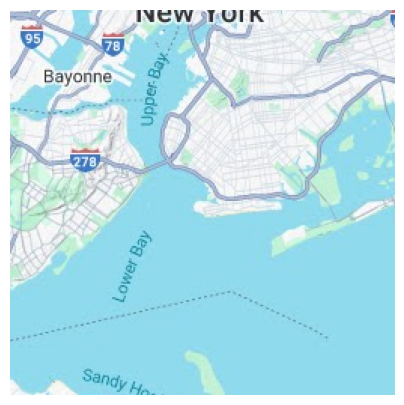

In [8]:
#upload your image and put the path here
from PIL import Image
#image_path = "data/10_301_384.png"  # Update with the path to your file
image_path = "data/10_301_385.png"  # Update with the path to your file


# Open the image file (replace with your local path)
image = Image.open(image_path)

# Show Image
image = Image.open(image_path)
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

## Making Predictions 🗺️📍

## GeoMapCLIP predictions

In [9]:
#Make predictions for GeoMapClip  TODO: replace model with our GeoMapClip
GM_top_pred_gps, GM_top_pred_prob = gmc_model.predict(image_path, top_k=50)

# Display the top 5 GPS predictions
print("Top 5 GPS Predictions by GeoMapCLIP 📍")
print("========================")
for i in range(5):
    lat, lon = GM_top_pred_gps[i]
    print(f"Prediction {i+1}: ({lat:.6f}, {lon:.6f}) - Probability: {GM_top_pred_prob[i]:.6f}")

Top 5 GPS Predictions by GeoMapCLIP 📍
Prediction 1: (40.847061, -74.003906) - Probability: 0.096387
Prediction 2: (40.847061, -72.597656) - Probability: 0.077163
Prediction 3: (40.847061, -73.652344) - Probability: 0.042109
Prediction 4: (40.847061, -72.949219) - Probability: 0.041164
Prediction 5: (41.112469, -73.300781) - Probability: 0.017861


In [10]:
# Make predictions
top_pred_gps, top_pred_prob = gc_model.predict(image_path, top_k=50)

# Display the top 5 GPS predictions
print("Top 5 GPS Predictions by GeoCLIP 📍")
print("========================")
for i in range(5):
    lat, lon = top_pred_gps[i]
    print(f"Prediction {i+1}: ({lat:.6f}, {lon:.6f}) - Probability: {top_pred_prob[i]:.6f}")

Top 5 GPS Predictions by GeoCLIP 📍
Prediction 1: (40.628880, -74.068146) - Probability: 0.024057
Prediction 2: (40.646652, -74.064331) - Probability: 0.020161
Prediction 3: (40.642452, -74.072311) - Probability: 0.017864
Prediction 4: (40.648705, -74.064911) - Probability: 0.017333
Prediction 5: (40.619293, -73.832069) - Probability: 0.014185


## Visualize Heatmap 🌎 🔍

In [11]:
# Set top coordinates to plot the heatmap (<= top_k)
top_n_coordinates = 10

gps_coordinates = top_pred_gps.tolist()[:top_n_coordinates]
probabilities = top_pred_prob.tolist()[:top_n_coordinates]

total_prob = sum(probabilities)
normalized_probs = [prob / total_prob for prob in probabilities]

# Combine coordinates with normalized probabilities
weighted_coordinates = [(lat, lon, weight) for (lat, lon), weight in zip(gps_coordinates, normalized_probs)]

# Calculate the average location to center the map
avg_lat = sum(lat for lat, lon, weight in weighted_coordinates) / len(weighted_coordinates)
avg_lon = sum(lon for lat, lon, weight in weighted_coordinates) / len(weighted_coordinates)

# Create a map centered around the average coordinates
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=2.2)

# Define the color gradient
magma = {
    0.0: '#932667',
    0.2: '#b5367a',
    0.4: '#d3466b',
    0.6: '#f1605d',
    0.8: '#fd9668',
    1.0: '#fcfdbf'
}


gradient = {str(k): v for k, v in magma.items()}

HeatMap(weighted_coordinates, gradient=gradient).add_to(m)

# Mark top coordinate
top_coordinate = gps_coordinates[0]
top_probability = normalized_probs[0]

folium.Marker(
    location=top_coordinate,
    popup=f"Top Prediction: {top_coordinate} with probability {top_probability:.4f}",
    icon=folium.Icon(color='orange', icon='star')
).add_to(m)


############################################ Draw result for GeoMapClip################################
GM_gps_coordinates = GM_top_pred_gps.tolist()[:top_n_coordinates]
probabilities = GM_top_pred_prob.tolist()[:top_n_coordinates]

total_prob = sum(probabilities)
normalized_probs = [prob / total_prob for prob in probabilities]

# Combine coordinates with normalized probabilities
weighted_coordinates = [(lat, lon, weight) for (lat, lon), weight in zip(GM_gps_coordinates, normalized_probs)]

# Define the bluish color gradient
bluish = {
    0.0: '#003366',  # Dark blue
    0.2: '#336699',  # Light blue
    0.4: '#66ccff',  # Lighter blue
    0.6: '#99ccff',  # Very light blue
    0.8: '#cce6ff',  # Soft blue
    1.0: '#e6f7ff'   # Very pale blue
}
gradient = {str(k): v for k, v in bluish.items()}

HeatMap(weighted_coordinates, gradient=gradient).add_to(m)

# Mark top coordinate
top_coordinate = GM_gps_coordinates[0]
top_probability = normalized_probs[0]

folium.Marker(
    location=top_coordinate,
    popup=f"Top Prediction: {top_coordinate} with probability {top_probability:.4f}",
    icon=folium.Icon(color='blue', icon='star')
).add_to(m)

# Display the map
m

## Want to learn more? 📚

Check out our [GitHub repository](https://github.com/junghawoo/geomap-clip) for more details!



## Acknowledgement
This notebook is adapted from the original GeoCLIP Colab example, available at [GeoCLIP repository] (https://github.com/VicenteVivan/geo-clip). <br>
For more information about GeoMapCLIP, visit our GeoMapCLIP repository [GitHub repository](https://github.com/junghawoo/geomap-clip)!